# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.446993,False,-2.350679
1,-0.681894,False,-2.784073
2,-0.556327,True,3.937857
3,0.082010,True,5.862821
4,0.404041,True,5.264265
...,...,...,...
995,0.172516,True,6.204782
996,-0.813132,False,-2.865673
997,-0.289953,False,0.332297
998,-1.261215,False,-1.705792


<AxesSubplot: xlabel='v0'>

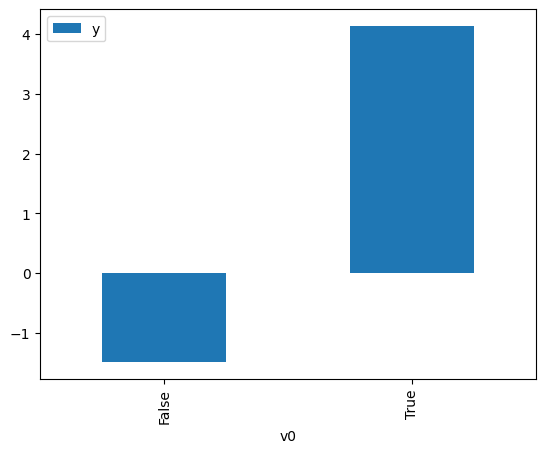

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

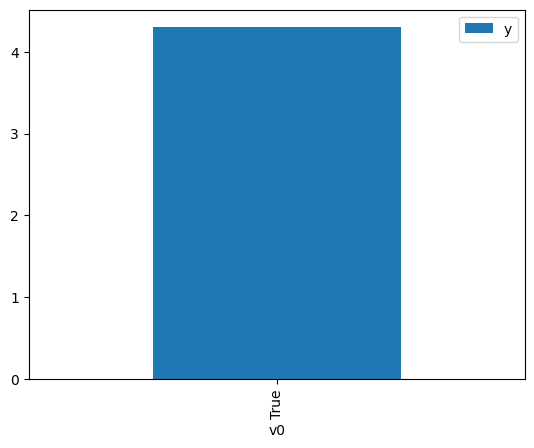

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.186882,False,-2.542879,0.959401,1.042317
1,-1.920396,False,-3.568476,0.993589,1.006452
2,-2.169765,False,-5.774178,0.996608,1.003404
3,-1.138616,False,-2.806103,0.954296,1.047893
4,-1.429839,False,-2.828588,0.977807,1.022697
...,...,...,...,...,...
995,-2.014711,False,-4.444674,0.994960,1.005066
996,-0.106583,False,0.774629,0.596892,1.675345
997,-1.035883,False,-3.058566,0.941331,1.062326
998,-1.857898,False,-4.340170,0.992484,1.007573


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.035242,True,3.193566,0.058760,17.018289
1,-0.744629,True,5.866203,0.116236,8.603150
2,-0.682048,True,3.998116,0.133762,7.475966
3,-1.035242,True,3.193566,0.058760,17.018289
4,-0.088300,True,4.686886,0.414438,2.412907
...,...,...,...,...,...
995,0.404041,True,5.264265,0.714385,1.399806
996,-1.702840,True,1.230174,0.011145,89.724836
997,0.373463,True,6.010123,0.698121,1.432415
998,-1.028467,True,3.294114,0.059728,16.742455


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              6431.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):                        0.00
Time:                        21:15:22   Log-Likelihood:                         -1448.2
No. Observations:                1000   AIC:                                      2900.
Df Residuals:                     998   BIC:                                      2910.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9448      0.026     75.078      0.000       1.894       1.996
x2             5.0244      0.066     76.308      0.000       4.895       5.154
==============================================================================
Omnibus:                        0.392   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.320
Skew:                          -0.039   Prob(JB):                        0.852
Kurtosis:                       3.038   Cond. No.                         2.56
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""